# MUDE W3- Gradient Estimation 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Info:</b> 

This notebook is a very simple draft showing how we could use data from the Nenana Ice Classic in the numerical modelling part.
The implementation is not very efficient, but it is very flexible.
 
The file can be either downloaded and loaded using path, or using a function to directly get the data from github
</p>
</div>


In [2]:
def import_data_browser(url):
    """
    This function imports data from a specified URL.

    Parameters:
    url (str): The URL from which to import the data.

    Returns:
    None

    Comments:
    This function is needed to load data in a browser, as the environment used does not support absolute/relative path imports 
    """
   
    response = requests.get(url)
    csv_data = StringIO(response.text)

    return csv_data
def plot_columns_interactive(df, column_groups: dict, title: str | None = None, 
                             xlabel: str | None = 'Date', 
                             y_domains: dict | None = None)-> go.Figure: 
    """
    Plot columns of a DataFrame in interactive plots with multiple y-axes using Plotly.

    Parameters
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    column_groups : dict
        A dictionary where keys are group names and values are lists of column names to be plotted together.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    date_focus : str, optional
        The initial focus point of the date selector buttons. Format: 'YYYY-MM-DD'.

    Returns
    -------
    fig : plotly.graph_objs.Figure
    """
    fig = go.Figure()
    
    num_groups = len(column_groups)
    y_domains = {i: [i / num_groups, (i + 1) / num_groups] for i in range(num_groups)}

    # Add traces for each column group with separate y-axes
    for i, (group_name, columns) in enumerate(column_groups.items(), start=1):
        y_axis = f'y{i}'
        for column in columns:
            if column in df.columns:
                fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name=f"{group_name}: {column}", yaxis=y_axis))
            else:
                print(f"Warning: Column '{column}' not found in DataFrame")
        
        # Update layout to add a new y-axis
        fig.update_layout(
            **{f'yaxis{i}': dict(
                title=f"{group_name}", 
                anchor='x', 
                overlaying='y', 
                side='left', 
                domain=y_domains.get(i-1, [0, 1]), 
                showline=True,
                linecolor="black",
                mirror=True,
                tickmode="auto",
                ticks="",
                titlefont={"color": "black"},
                type="linear",
                zeroline=False
            )}
        )
    
    # General layout updates
    fig.update_layout(
        title=title,
        xaxis=dict(
            title=xlabel, 
            rangeslider=dict(visible=True), 
            type="date",
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        ),
        dragmode="zoom",
        hovermode="x",
        legend=dict(traceorder="reversed",
        x=0,
        y=1,
        xanchor='left',
        yanchor='top',
        orientation='v'
    ),
        height=800,
        template="plotly",
        margin=dict(t=90, b=150)
    )

    # Add break up times shapes if necessary
    file3=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/Time_series_DATA.txt')
    break_up_times = pd.read_csv(file3)
    break_up_times['timestamp'] = pd.to_datetime(break_up_times[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    break_up_times.set_index('timestamp', inplace=True)
    shapes = []
    for date in break_up_times.index:
        shape = {"type": "line", "xref": "x", "yref": "paper", "x0": date, "y0": 0, "x1": date, "y1": 1,
                 "line": {"color": 'red', "width": 0.6, "dash": 'dot'}, 'name': 'break up times'}
        shapes.append(shape)

    fig.update_layout(shapes=shapes)
    # dumm line to add to legend
    fig.add_trace(go.Scatter(
        x=[None], y=[None],  
        mode='lines',
        line=dict(color='red', width=0.6, dash='dot'),
        name='Break Up Times',  
        hoverinfo='none',  \
        showlegend=True     
    ))
    #fig.show()
    return fig


In [9]:
from io import StringIO
import requests
import pandas as pd
import matplotlib.pyplot as plt



# we could load the data from the repo

#Data=pd.read_csv("../data_files/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')

# or we could load the data from the web ( by fetching the file from github )
file=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/Time_series_DATA.txt')
Data=pd.read_csv(file,skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39309 entries, 1901-02-01 to 2024-02-06
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29547 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22562 non-null  float64
 8   Nenana: Air temperature [C]                        31171 non-null  fl

Lets plot the raw timseries without any modifications

<module 'matplotlib.pyplot' from 'c:\\Users\\gabri\\anaconda3\\envs\\iceclassic\\Lib\\site-packages\\matplotlib\\pyplot.py'>

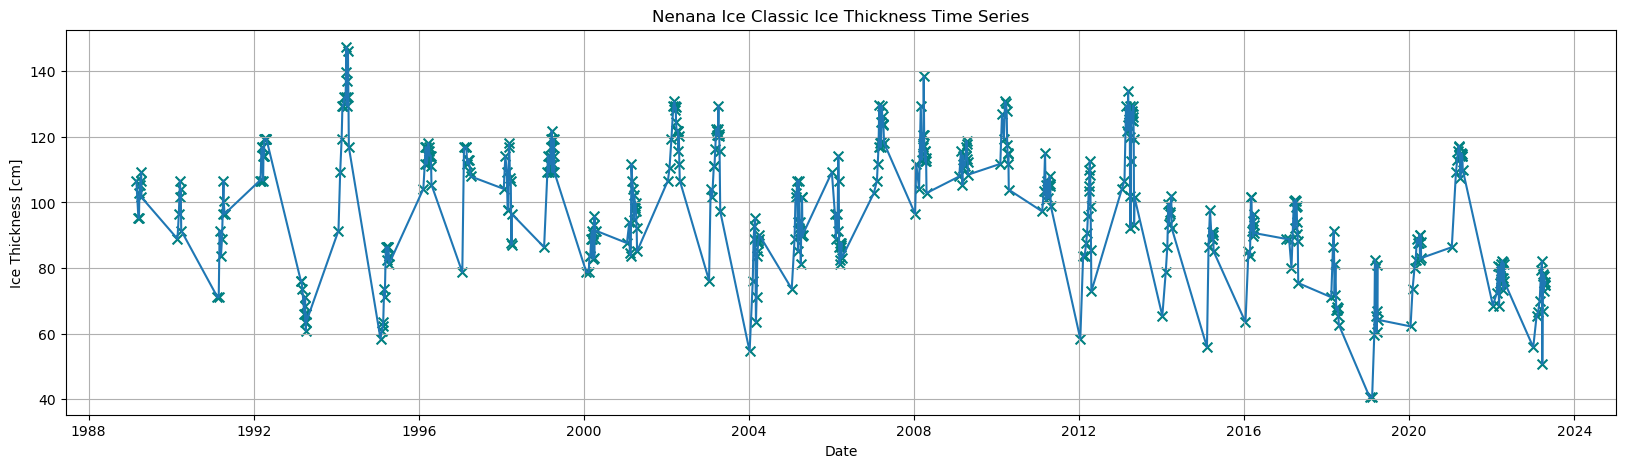

In [21]:
Ice_thickness=Data['IceThickness [cm]']
Ice_thickness=Ice_thickness.dropna(inplace=False) # drop the missing values

plt.figure(figsize=(20,5))
plt.plot(Ice_thickness)
plt.scatter(Ice_thickness.index,Ice_thickness,color='teal',marker='x',s=50)
plt.title('Nenana Ice Classic Ice Thickness Time Series')
plt.ylabel('Ice Thickness [cm]')
plt.xlabel('Date')
plt.grid()
plt

Instead of vectoring the code, we will group the data by year,because the sampling is irregular across all years an also within each year ( starts first week of jan, the sampling gets faster as the break-up date parches(or as the people doing the measurement estimates)).

Lets use the interative function so we can zoom-in/scroll to get a better feeling for the data.